In [1]:
import os
os.getcwd()

'C:\\Users\\User\\Documents\\Studia\\NLP\\project2\\src'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
plt.style.use("fivethirtyeight")

In [3]:
name = 'own_lstm'
data = '../data/own_mod.parquet'

## 1: Load data

In [4]:
df = pd.read_parquet(data)
df

,text,score
0,description say maybe cream cheese cream chees...,1
1,terrible followed recipe exactly tasted fine a...,1
2,im always amazed people rate recipe state chan...,1
3,didnt like creamy rich didnt feel good sour cr...,1
4,even using green chilies much hot u like,1
...,...,...
1407,good omitted green chilies dont like lot heat ...,5
1408,cut calorie fat way using nonfat sour cream su...,5
1409,wonderful recipe used oz light cream cheese in...,5
1410,good thing would leave salt use lower sodium b...,5


### 2.3 Feature Extraction

#### 2.3.1 Tokenization

In [5]:
n_words = 2000

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(df.text)
total_words = len(tokenizer.word_index) + 1
total_words

3450

In [6]:
X = tokenizer.texts_to_sequences(df.text)
X

[[901, 116, 86, 10, 17, 10, 17, 1, 53, 116, 43, 10, 195, 10, 10, 17],
 [271, 59, 1, 87, 117, 375, 9, 43, 10, 195, 10, 74, 261, 54, 1049, 18, 602],
 [67,
  141,
  1050,
  149,
  794,
  1,
  643,
  349,
  1,
  1750,
  331,
  488,
  60,
  226,
  67,
  96,
  902,
  36,
  40,
  1,
  149,
  167,
  1,
  123,
  1313,
  1751,
  168,
  175,
  1,
  5,
  36,
  1314,
  794],
 [20, 5, 262, 304, 20, 514, 4, 43, 10, 112, 195, 10, 1315, 1051, 51, 195, 10],
 [36, 190, 61, 204, 24, 191, 251, 5],
 [1316, 18, 1752, 49, 18, 7, 1753, 18, 30, 54, 14, 18, 1754],
 [3, 7, 5, 168, 1, 400, 13, 2, 454, 1, 89, 62, 75],
 [376,
  1052,
  1,
  8,
  118,
  1755,
  263,
  30,
  24,
  1756,
  176,
  1053,
  1317,
  1318,
  720,
  51,
  47],
 [141,
  176,
  118,
  47,
  1,
  1757,
  1758,
  102,
  1,
  177,
  196,
  205,
  116,
  4,
  13,
  206,
  150,
  65,
  432,
  86,
  104,
  105,
  555,
  401,
  183,
  252,
  5,
  11,
  903,
  1759,
  1760],
 [59,
  1,
  1761,
  142,
  210,
  1762,
  904,
  1763,
  113,
  316,
  1764,

In [7]:
max_length = max([len(seq) for seq in X])
max_length

135

In [8]:
X = np.array(pad_sequences(X, maxlen=max_length, padding='pre'))

## 2.4 Split Dataset

In [9]:
Y = np.array([[y>1, y>2, y>3, y>4] for y in df.score])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

del X
del Y

## 3 Build model

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [12]:
model_input = layers.Input((max_length,))
l = layers.Embedding(n_words + 1, 64, input_length = max_length)(model_input)
l = layers.LSTM(64, activation='tanh', return_sequences=True)(l)
l = layers.Dropout(0.1)(l)
l = layers.LSTM(32, activation='tanh', return_sequences=False)(l)
l = layers.Dropout(0.2)(l)
l = layers.Dense(16, activation='relu')(l)
l = layers.Dropout(0.3)(l)
model_output = layers.Dense(4, activation='sigmoid')(l)

model = keras.Model(model_input, model_output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 135)]             0         
                                                                 
 embedding (Embedding)       (None, 135, 64)           128064    
                                                                 
 lstm (LSTM)                 (None, 135, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 135, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528   

In [14]:
def score_accuracy(y_true, y_pred):
    return tf.math.reduce_sum(y_true, axis=1) == tf.math.round(tf.math.reduce_sum(y_pred, axis=1))

def score_distance(y_true, y_pred):
    return tf.math.abs(tf.math.reduce_sum(y_true, axis=1) - tf.math.round(tf.math.reduce_sum(y_pred, axis=1)))

In [15]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=[score_accuracy, score_distance])

In [16]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data = (X_test, y_test)
)

Epoch 1/50
18/18 [==============================] - 5s 63ms/step - loss: 0.6749 - score_accuracy: 0.2108 - score_distance: 1.2037 - val_loss: 0.6222 - val_score_accuracy: 0.2191 - val_score_distance: 1.1837
Epoch 2/50
18/18 [==============================] - 0s 20ms/step - loss: 0.6248 - score_accuracy: 0.2126 - score_distance: 1.2188 - val_loss: 0.5962 - val_score_accuracy: 0.2191 - val_score_distance: 1.1837
Epoch 3/50
18/18 [==============================] - 0s 20ms/step - loss: 0.6110 - score_accuracy: 0.2099 - score_distance: 1.2037 - val_loss: 0.5942 - val_score_accuracy: 0.2191 - val_score_distance: 1.1837
Epoch 4/50
18/18 [==============================] - 0s 19ms/step - loss: 0.5933 - score_accuracy: 0.2188 - score_distance: 1.1860 - val_loss: 0.5486 - val_score_accuracy: 0.2191 - val_score_distance: 1.1802
Epoch 5/50
18/18 [==============================] - 0s 20ms/step - loss: 0.5163 - score_accuracy: 0.2737 - score_distance: 1.0115 - val_loss: 0.4899 - val_score_accuracy: 0

In [55]:
model.save(f'../models/{name}')

INFO:tensorflow:Assets written to: ../models/amz_lstm\assets


INFO:tensorflow:Assets written to: ../models/amz_lstm\assets


In [56]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,score_accuracy,score_distance,val_loss,val_score_accuracy,val_score_distance
0,0.286148,0.595460,0.532812,0.256647,0.620506,0.484181
1,0.257084,0.638911,0.467674,0.242685,0.658240,0.440958
2,0.242488,0.660764,0.433344,0.234738,0.678937,0.414510
3,0.231100,0.676634,0.408674,0.228477,0.688603,0.399495
4,0.220312,0.692570,0.384097,0.225654,0.703407,0.383161


In [57]:
hist_df.to_csv(f'../logs/{name}.csv')

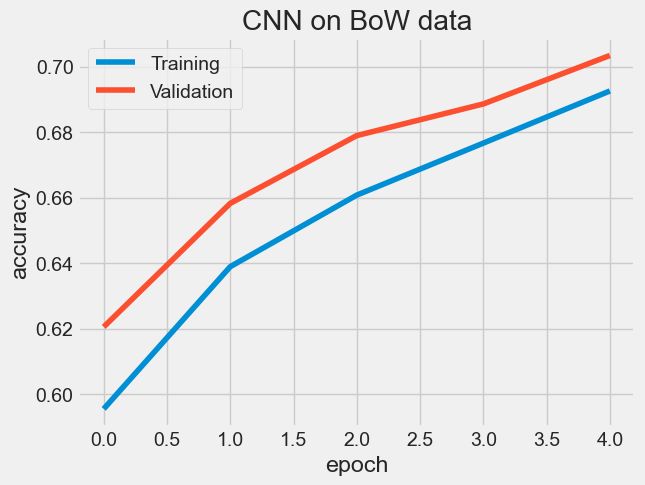

In [58]:
plt.title('CNN on BoW data')

plt.plot(hist_df.score_accuracy, label='Training')
plt.plot(hist_df.val_score_accuracy, label='Validation')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.savefig(f'../figs/{name}.png')
plt.show()